Group 7 Opti project:  

> The scenario of our project is that we want to start a small food delivery business within SUTD, with our 4 members as the riders  
- The goal of the project is to minimize the number of drivers we employ while fulfilling all the demand each hour   
- The demand data is obtained through a survey done by the SUTD population  
- We employ drivers by the hour



> Some possible ideas for improving the model:  
- Adding a indicator variable to model a possible condition (e.g. We have a friend who only wants to work when demand exceeds a certain level, so a fifth driver (x5) would only be available if d exceeds a certain amount)
- Adding additional constraints to model: Driver 1 & 4 don't like working with each other, so if x1 is 1, x4 cannot be 1 & vice versa


In [ ]:
# Import
import matplotlib.pyplot as plt
import pandas as pd

# Read the data from an Excel file
df = pd.read_excel('demand_counts.xlsx') 

# Extract the hour from the Time Slot column
df['Hour'] = df['Time Slot'].str.split('-').str[0].str.strip()

# Create the plot
plt.figure(figsize=(12, 6))
plt.bar(df['Hour'], df['Count'])

# Set the title and labels
plt.title('Count by Time Slot (Start)')
plt.xlabel('Time Slot (Start)')
plt.ylabel('Count')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()


In [15]:
using MosekTools, JuMP

------START OF MODEL------   
Objective function:

In [17]:
#Start the model
m = Model(Mosek.Optimizer)
n = 4 #Number of drivers
k = 24 #Number of hours in the day
d = [11 10 13 2 0 0 5 9 12 16 17 4 25 28 8 2 1 4 20 23 14 5 2 2] # Demand in each hour

p = [30 4 2 1] # Productivity of each driver      # idea is to randomize this as an input for the driver's productivity

#Start variables
@variable(m, x[1:n,1:k], Bin) # Whether I employ driver i in hour j

#Start constraints and objective
@constraint(m, [j=1:k], sum(p[i] * x[i, j] for i in 1:n) >= d[j]) # the sum of (productivity of driver i * whether or not that driver is 
                                                                  # employed in hour i)
                                                                  # across all drivers must be more than or equals to the demand for that hour i

@objective(m, Min, sum(x[i, j] for i in 1:n, j in 1:k))
print(m)






In [18]:
optimize!(m)

Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : LO (linear optimization problem)
  Constraints            : 120             
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 96              
  Matrix variables       : 0               
  Integer variables      : 96              

Optimizer started.
Mixed integer optimizer started.
Threads used: 12
Presolve started.
Presolve terminated. Time = 0.00, probing time =  0.00
Presolved problem: 8 variables, 2 constraints, 8 non-zeros
Presolved problem: 0 general integer, 8 binary, 0 continuous
Clique table size: 2
Symmetry factor  : 1.00 (detection time = 0.00)
BRANCHES RELAXS   ACT_NDS  DEPTH    BEST_INT_OBJ         BEST_RELAX_OBJ       REL_GAP(%)  TIME  
0        0        1        0        2.3000000000e+01     NA                   NA          0.0   
0        1

In [19]:
value.(x)

4×24 Matrix{Float64}:
 1.0  1.0  1.0  0.0  0.0  0.0   1.0  …  0.0  1.0  1.0  1.0   1.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  -0.0     1.0  0.0  0.0  0.0  -0.0  1.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  -0.0     0.0  0.0  0.0  0.0  -0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  -0.0     0.0  0.0  0.0  0.0  -0.0  0.0  0.0

In [26]:
show(value.(x))

[1.0 1.0 1.0 0.0 0.0 0.0 1.0 1.0 1.0 1.0 1.0 0.0 1.0 1.0 1.0 0.0 0.0 0.0 1.0 1.0 1.0 1.0 0.0 0.0; 0.0 0.0 0.0 1.0 0.0 0.0 -0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 0.0 1.0 1.0 1.0 0.0 0.0 0.0 -0.0 1.0 1.0; 0.0 0.0 0.0 0.0 0.0 0.0 -0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.0 0.0 0.0 0.0 0.0 -0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 -0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.0 0.0 0.0]

In [20]:
objective_value(m)

22.0

> We got bought over by a STEP student & get paid now. This scenario is now from the perspective of the owner
- The goal is to minimize total cost (Fixed & variable cost) while meeting the demand in every hour in every hotspot
- Variable cost is straight line distance, fixed cost is salary
- Every hour's total demand is split randomly into k "hotspots"
- The driver's and demand hotspot locations are fixed (HQ hotspots)

> Problems of model
- Problem feasibility still limited by the p vector 
- Only variable cost stops most productive driver from doing everything

In [58]:
using JuMP, MosekTools, LinearAlgebra, Random, Plots
import LinearAlgebra
import Plots
import Random

In [59]:
# Helper function to randomly split an integer into n positive integers
function random_split(total::Int, n::Int)
    cuts = sort(rand(1:total-1, n-1))
    return diff([0; cuts; total])
end

random_split (generic function with 1 method)

In [90]:
Random.seed!(1020)

rangelct = 10_000 # Coordinate range 
num_hotspots = 15   # Number of delivery locations/hotspots
num_drivers = 10    # Number of drivers

d = [22 20 26 4 0 0 10 19 24 40 34 4 25 36 8 2 1 4 20 23 14 5 2 2] # Demand vector from data

d_short = partialsort(vec(d), 1:3, rev=true)[1:3] # Extract top 3 values from 'd'

x_h_coords = rand(num_hotspots) * rangelct # Vector of x coordinates for hotspot coordinates
y_h_coords = rand(num_hotspots) * rangelct # Vector of y coordinates for hotspot coordinates

x_d_coords = rand(num_drivers) * rangelct  # Vector of x coordinates for driver coordinates 
y_d_coords = rand(num_drivers) * rangelct  # Vector of y coordinates for driver coordinates

# Split demand into 15 (arbitrary!) elements, 5 x length of d_short
tuples = [] # Array of tuples containing hotspot info
for i in 1:length(d_short)
    demand_hour_i = d_short[i]
    split_demand = random_split(demand_hour_i, num_hotspots)  # splits for each element of d_short

    # Create 15 tuples for the current d_short value
    for j in 1:num_hotspots
        push!(tuples, (x_h_coords[j], y_h_coords[j], split_demand[j]))
    end
end

In [91]:
c = zeros(num_hotspots, num_drivers) # I'm creating a 15x10 matrix. Each matrix is fixed for that hour,                        
                                     # and the rows are the order hotspots while the columns are the drivers.                  
                                     # Each cell is the variable cost incurred for assigning driver i to order demand hotspot j
for i in 1:num_hotspots
    for j in 1:num_drivers
        c[i, j] = norm([x_h_coords[i] - x_d_coords[j], y_h_coords[i] - y_d_coords[j]])
    end
end

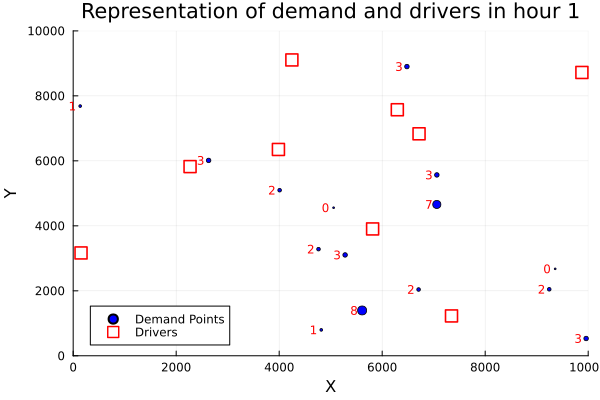

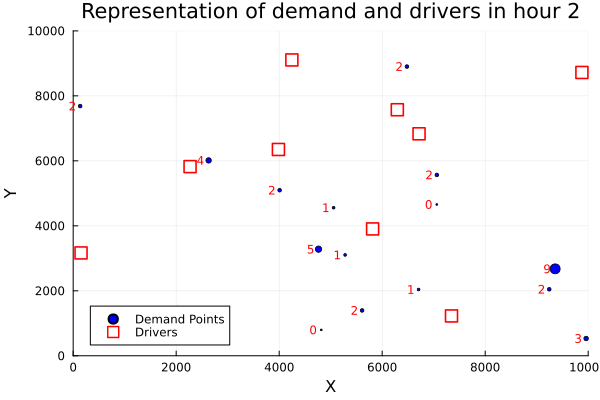

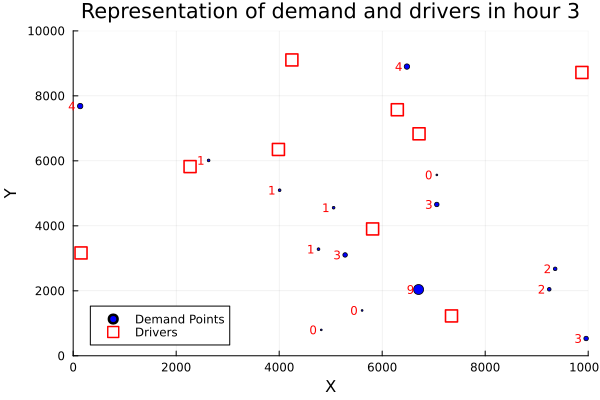

In [92]:
n_plots = 3 # To plot 3 hours together

# Plotting the 3 graphs
for i in 1:n_plots
    current_tuples = tuples[(i-1)*num_hotspots + 1:i*num_hotspots]

    # Extract the x_c, y_c values (demand locations) and demand (d_val)
    x_c_plot = [t[1] for t in current_tuples]
    y_c_plot = [t[2] for t in current_tuples]
    d_vals_plot = [t[3] for t in current_tuples] 

    # Create the scatter plot for demand points
    p = scatter(
        x_c_plot, y_c_plot; # Use extracted plot-specific coordinates
        label = "Demand Points",
        markershape = :circle,
        markercolor = :blue,
        markersize = 0.5 .* (2 .+ d_vals_plot), # Use plot-specific demand values
        title = "Representation of demand and drivers in hour $(i)",
        xlabel = "X",
        ylabel = "Y",
        xlims = (0, rangelct),
        ylims = (0, rangelct),
    )
    
    # Annotate each demand point slightly to the left with red text
    for (xi, yi, di) in zip(x_c_plot, y_c_plot, d_vals_plot)
        annotate!(p, xi - 0.01 * rangelct, yi, text(string(di), 8, :red, :right)) # Adjust offset by rangelct for better scaling
    end
    
    # Add the driver points (constant across plots)
    scatter!(p,
        x_d_coords, y_d_coords, # Use the extracted driver coordinates
        label = "Drivers",
        markershape = :rect,
        markercolor = :white,
        markersize = 6,
        markerstrokecolor = :red,
        markerstrokewidth = 2
    )

    # Display the plot
    display(p)
end

> Hour 1's model!

In [93]:
# Start the model
model = Model(Mosek.Optimizer)
num_drivers = 10 # Number of drivers
h = 24 # Number of hours in the day
num_hotspots = 15 #number of hotspots

# Productivity of drivers
pr = [5 4 3 5 5 6 8 4 3 7]                         # Still can randomize this OR draw from normal dist
fixed_c = [2]

# Variables
@variable(model, y[1:num_drivers, 1:num_hotspots], Bin) # Binary Desc variable of whether driver is assigned to hotspot 

# Constraints
for j in 1:num_hotspots # For every hotspot, sum of all driver's productivity must meet or exceed demand
    @constraint(model, sum(y[i,j]*pr[i] for i in 1:num_drivers) >= tuples[j][3]) # Tuples is a vector that has tuples that contains the x_coord,
                                                                                 # y_coord and the demand
end

# Objective
@objective(model, Min,                             
    sum(y[i,j]*fixed_c[1] for i in 1:num_drivers, j in 1:num_hotspots) + # Fixed component
    sum(y[i,j] * c[j,i] for i in 1:num_drivers, j in 1:num_hotspots)     # Variable component based on distance
    )

print(model)

In [94]:
optimize!(model)

Problem
  Name                   :                 
  Objective sense        : minimize        
  Type                   : LO (linear optimization problem)
  Constraints            : 165             
  Affine conic cons.     : 0               
  Disjunctive cons.      : 0               
  Cones                  : 0               
  Scalar variables       : 150             
  Matrix variables       : 0               
  Integer variables      : 150             

Optimizer started.
Mixed integer optimizer started.
Threads used: 12
Presolve started.
Presolve terminated. Time = 0.00, probing time =  0.00
Presolved problem: 130 variables, 13 constraints, 130 non-zeros
Presolved problem: 0 general integer, 130 binary, 0 continuous
Clique table size: 0
BRANCHES RELAXS   ACT_NDS  DEPTH    BEST_INT_OBJ         BEST_RELAX_OBJ       REL_GAP(%)  TIME  
0        0        1        0        2.1284711722e+04     NA                   NA          0.0   
0        1        1        0        2.1284711722e+0

In [95]:
value.(y)

10×15 Matrix{Float64}:
 -0.0  -0.0  -0.0  -0.0   1.0  -0.0  …  -0.0  -0.0  -0.0  0.0   1.0  -0.0
 -0.0  -0.0  -0.0  -0.0  -0.0  -0.0     -0.0  -0.0  -0.0  0.0  -0.0  -0.0
 -0.0  -0.0  -0.0  -0.0  -0.0  -0.0     -0.0   1.0  -0.0  0.0  -0.0  -0.0
 -0.0  -0.0  -0.0  -0.0  -0.0  -0.0     -0.0  -0.0  -0.0  0.0  -0.0  -0.0
 -0.0  -0.0  -0.0  -0.0  -0.0  -0.0     -0.0  -0.0  -0.0  0.0  -0.0  -0.0
 -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  …   1.0  -0.0  -0.0  0.0  -0.0  -0.0
 -0.0   1.0   1.0   1.0  -0.0   1.0     -0.0  -0.0  -0.0  0.0  -0.0  -0.0
  1.0  -0.0  -0.0  -0.0  -0.0  -0.0     -0.0  -0.0  -0.0  0.0  -0.0  -0.0
 -0.0  -0.0  -0.0  -0.0  -0.0  -0.0     -0.0  -0.0  -0.0  0.0  -0.0   1.0
 -0.0  -0.0  -0.0  -0.0  -0.0  -0.0     -0.0  -0.0   1.0  0.0  -0.0  -0.0

In [96]:
objective_value(model)

21284.71172216351

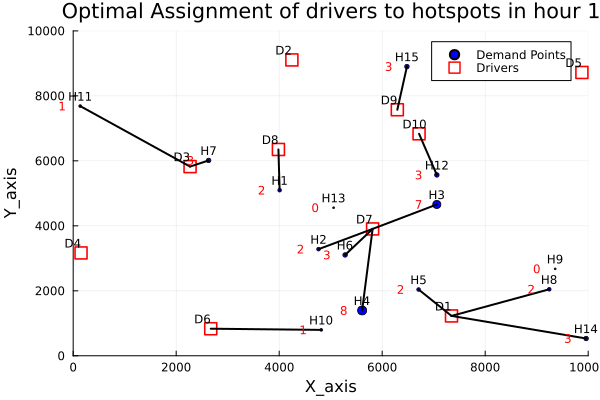

In [97]:
using Plots

y_val = value.(y) # optimized assignments

# Extract data for plotting
current_tuples = tuples[1:15]
x_c = [t[1] for t in current_tuples]
y_c = [t[2] for t in current_tuples]
d   = [t[3] for t in current_tuples]

# Define common plot attributes for demand points
demand_point_attrs = (
    label       = "Demand Points",
    markershape = :circle,
    markercolor = :blue,
    markersize  = 0.5 .* (2 .+ d), # To make larger demand points larger in size
    legend      = :topright,
    legendfontsize = 8
)

# Define common plot attributes for drivers
driver_attrs = (
    label           = "Drivers",
    markershape     = :rect,
    markercolor     = :white,
    markersize      = 6,
    markerstrokecolor = :red,
    markerstrokewidth = 2
)

# Initialize the plot with Demand Points
p = scatter(
    x_h_coords, y_h_coords;
    demand_point_attrs..., 
    title           = "Optimal Assignment of drivers to hotspots in hour 1",
    xlabel          = "X_axis",
    ylabel          = "Y_axis",
    xlims           = (0,rangelct),
    ylims           = (0,rangelct)
)

# Label hotspots and numeric demand for demand points
for (idx, xi, yi, di) in zip(1:length(x_h_coords), x_h_coords, y_h_coords, d)
    # Hotspot label (e.g., H1)
    annotate!(p, xi, yi + 0.03*rangelct, text("H$(idx)", 8, :black, :center))
    # Numeric demand (e.g., 5)
    annotate!(p, xi - 0.03*rangelct, yi, text(string(di), 8, :red, :right))
end

# Add Drivers to the plot
scatter!(p, x_d_coords, y_d_coords; driver_attrs...)

# Label each driver
for (idx, xi, yi) in zip(1:num_drivers, x_d_coords, y_d_coords)
    annotate!(p, xi - 0.03*rangelct, yi+ 0.03*rangelct, text("D$(idx)", 8, :black, :left))
end

# Draw assignment lines
for j in 1:num_hotspots, i in 1:num_drivers
    if y_val[i,j] == 1
        plot!(p, [x_h_coords[j], x_d_coords[i]], [y_h_coords[j], y_d_coords[i]];
              color = :black, label = "", linewidth = 2)
    end
end

display(p)

In [98]:
c[4,1]

1743.7294129299773

In [99]:
c[4,7]

2517.95216352295